## Settings

In [1]:
import os
from os.path import join as osj
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import json
from workoutdetector.datasets import RepcountHelper

In [2]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.autolayout'] = True
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 0.8
COLORS = list(plt.get_cmap('Set3').colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300

In [3]:
helper = RepcountHelper('../data/RepCount/', '../data/RepCount/annotation.csv') 
info = helper.get_rep_data(['test'], action=['all'])
CLASSES = helper.classes
print(CLASSES)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


In [32]:
from scipy.signal import find_peaks
from workoutdetector.utils.inference_count import pred_to_count, write_to_video
from workoutdetector.utils import plot_all, plot_per_action, plot_pred, plt_params
plt.rcParams.update(plt_params())

## Count

In [5]:
video_save_dir = '../out/acc_0.841_epoch_26_20220711-191616_1x1'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(video_json)

stu10_69.mp4.stride_1_step_1.json


train2568.mp4 pull_up
count = 3
pred count = 4


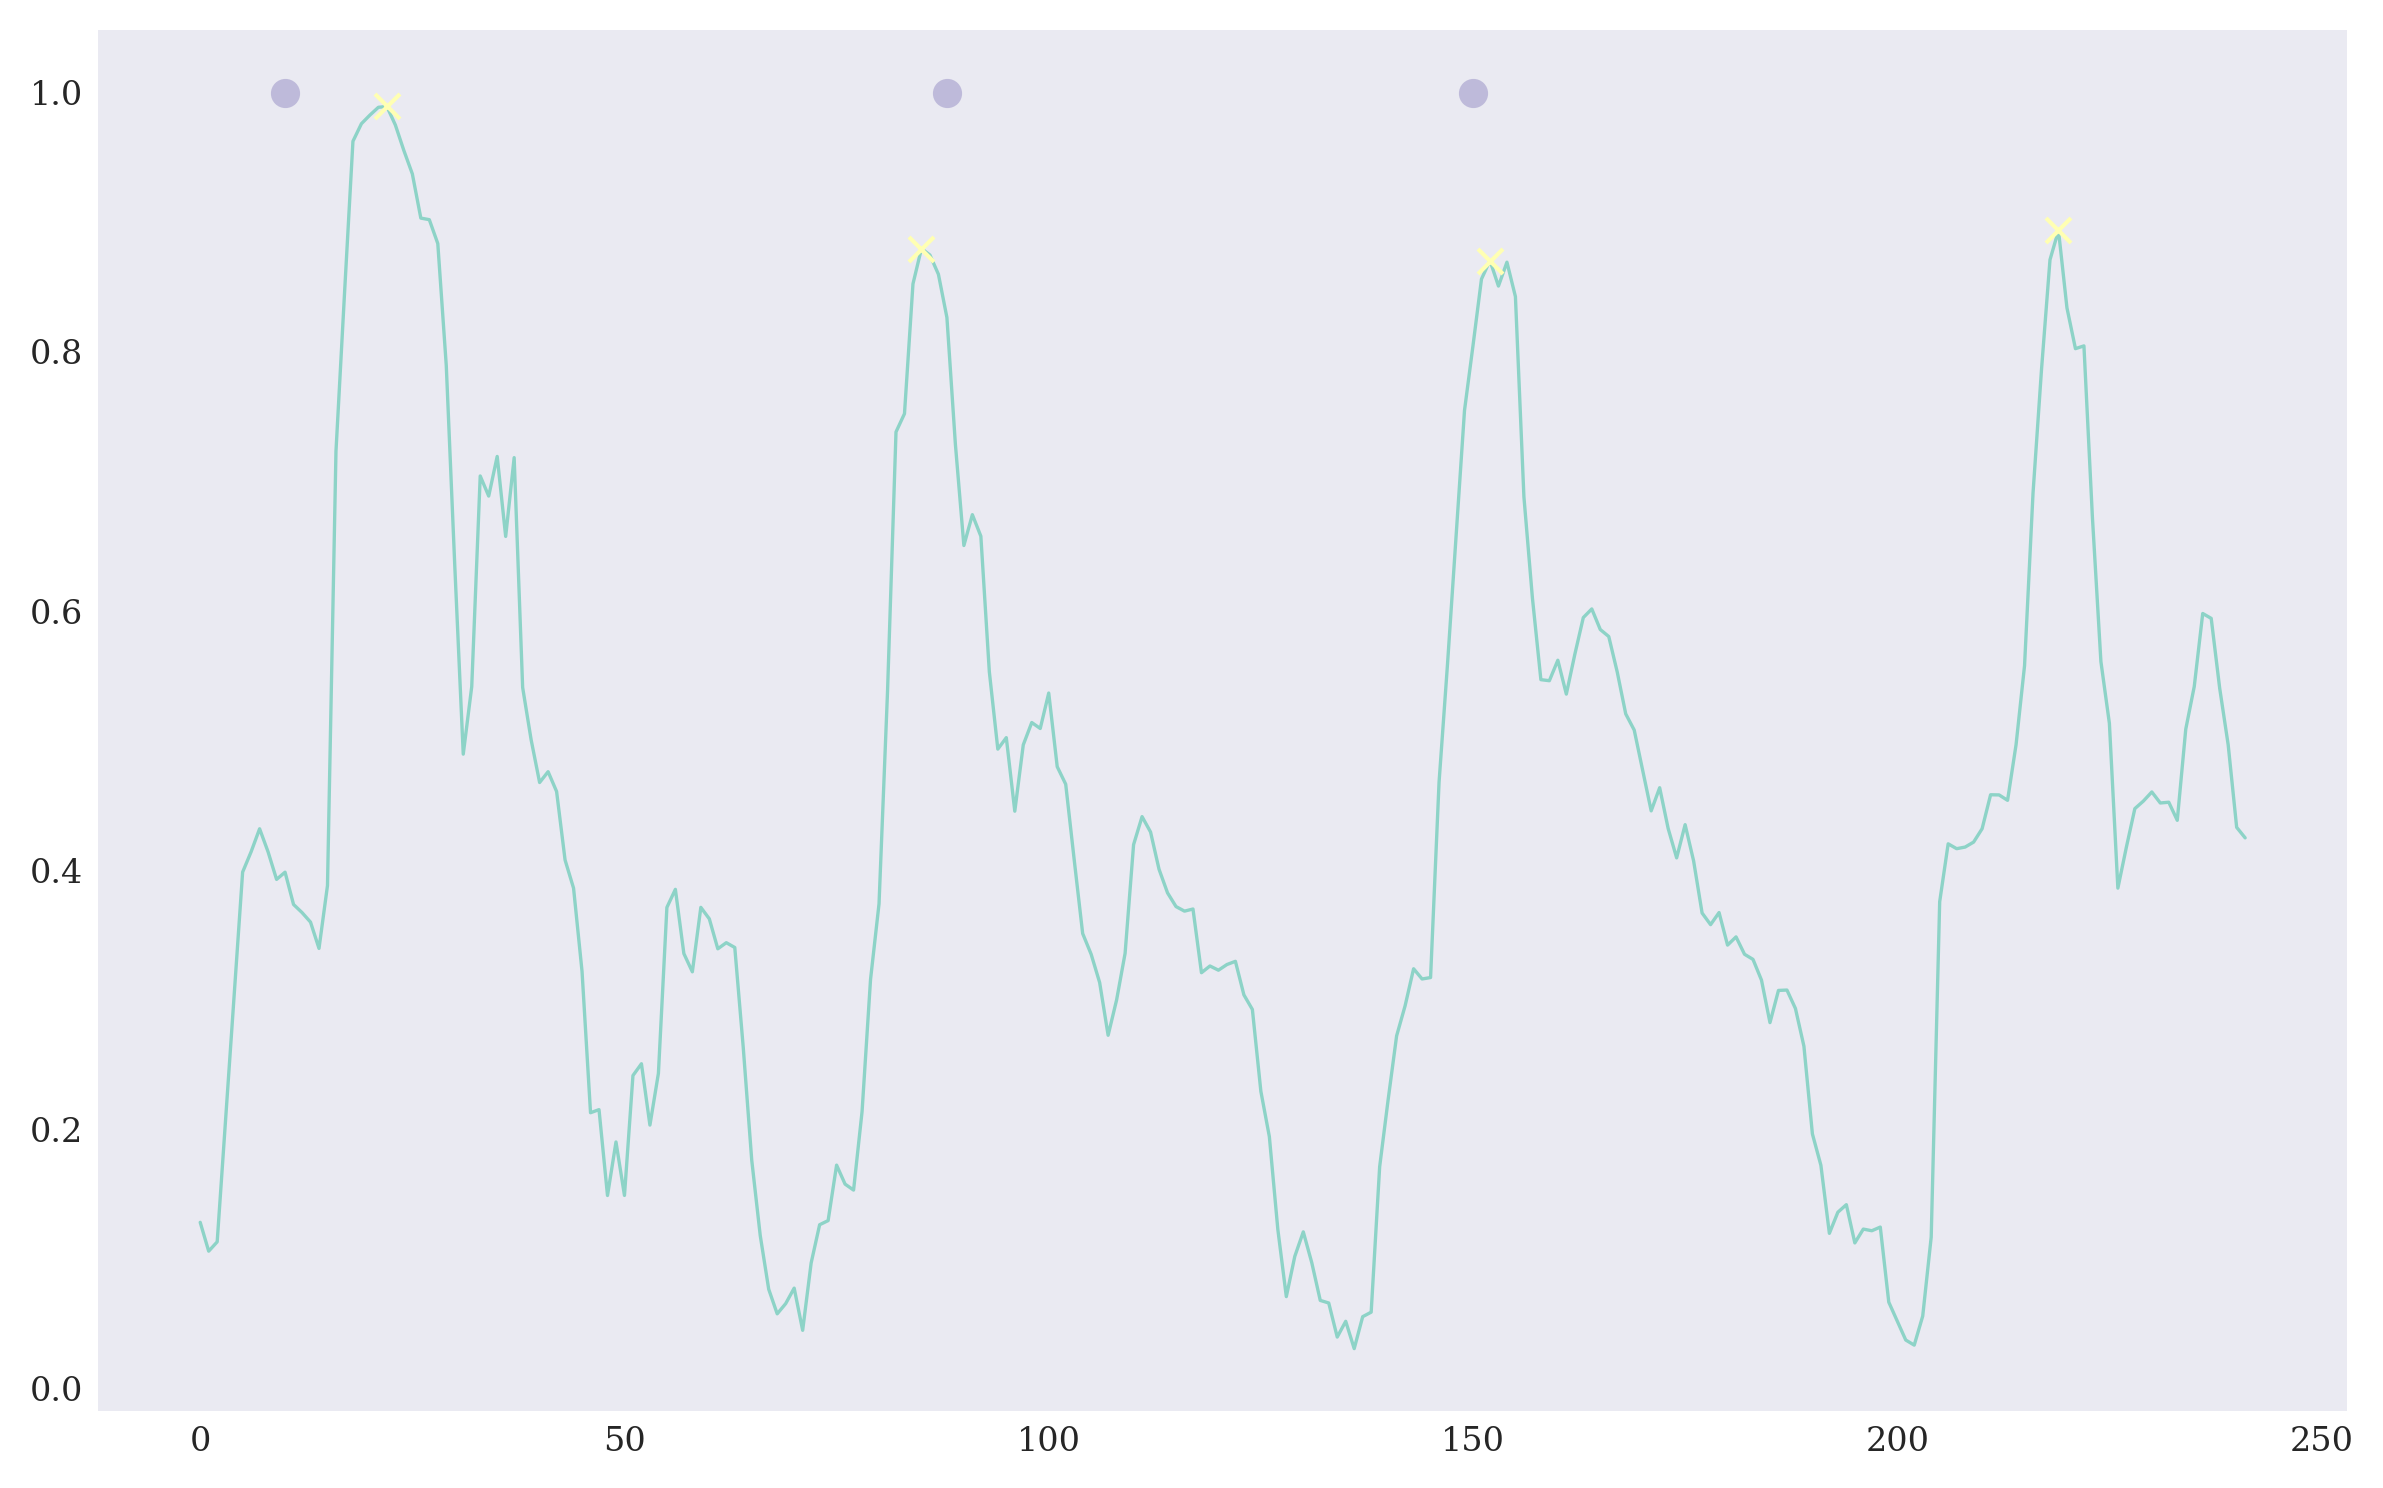

In [115]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
gt = np.array(js['ground_truth'])
cls_idx = CLASSES.index(js['action'])
score = js['scores']
score_arr = np.array([list(d.values()) for d in score.values()])
softmax_score_arr = np.exp(score_arr) / np.sum(np.exp(score_arr), axis=1, keepdims=True)
threshold = 0.5
print(js['video_name'], js['action'])
print('count =', len(gt)//2)
peaks = find_peaks(softmax_score_arr[:, 2*cls_idx], height=threshold, distance=20)
print('pred count =', len(peaks[0]))
plt.plot(softmax_score_arr[:, 2*cls_idx])
plt.plot(peaks[0], softmax_score_arr[peaks[0], 2*cls_idx], 'x')
plt.plot(gt[0::2], np.ones(len(gt)//2), 'o')
plt.show()

In [85]:
print(js['video_name'], js['action'])
print(js['ground_truth'])

stu6_68.mp4 squat
[4, 7, 8, 11, 11, 14, 14, 18, 18, 21, 23, 26]


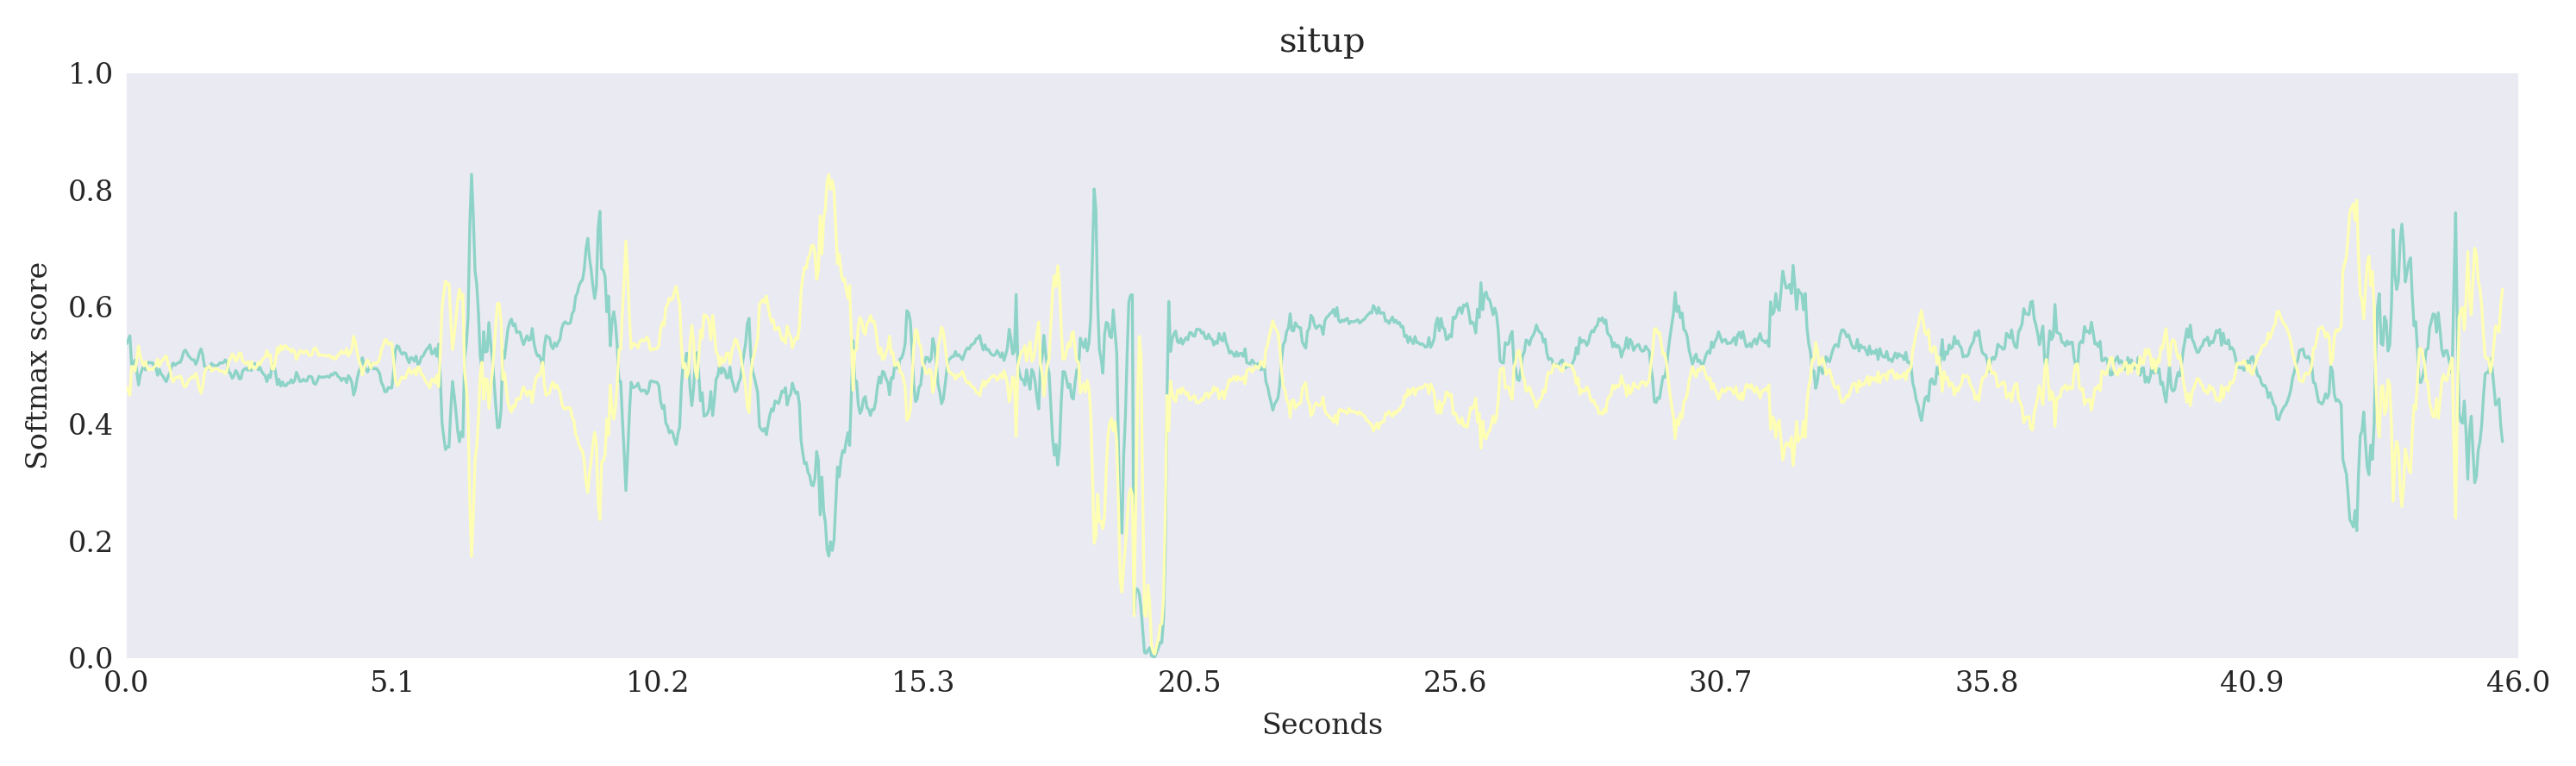

In [20]:
plot_per_action(js, softmax=True, action_only=True)

## Plot predictions

stu6_16.mp4
[19, 36, 52, 64, 81, 92, 107, 119, 135, 147, 163, 176, 191, 202, 217, 229, 244, 255, 271, 283, 298, 310, 326, 338, 354, 365, 381, 393, 408, 420, 435, 446, 462, 473, 488, 499, 514, 525, 540, 551, 567, 578, 592, 604, 619, 630, 646, 657, 672, 684, 699, 710, 726, 737, 752, 763, 778, 789, 804, 816, 831, 843, 858, 869, 884, 896, 911, 922, 938, 949, 964, 975, 990, 1001, 1016, 1028, 1043, 1055, 1070, 1082, 1097, 1108, 1123, 1136, 1151, 1163, 1178, 1190, 1205, 1216, 1232, 1243, 1258, 1270, 1285, 1297, 1312, 1324, 1338, 1350, 1364, 1375, 1391, 1403, 1418, 1429, 1444, 1455, 1470, 1482, 1497, 1509, 1526, 1537, 1552, 1563, 1578, 1590, 1606, 1617, 1632, 1644, 1659, 1671, 1686, 1697, 1712, 1724, 1740, 1751, 1766, 1778]
gt=66, pred=66
Absolute diff 0


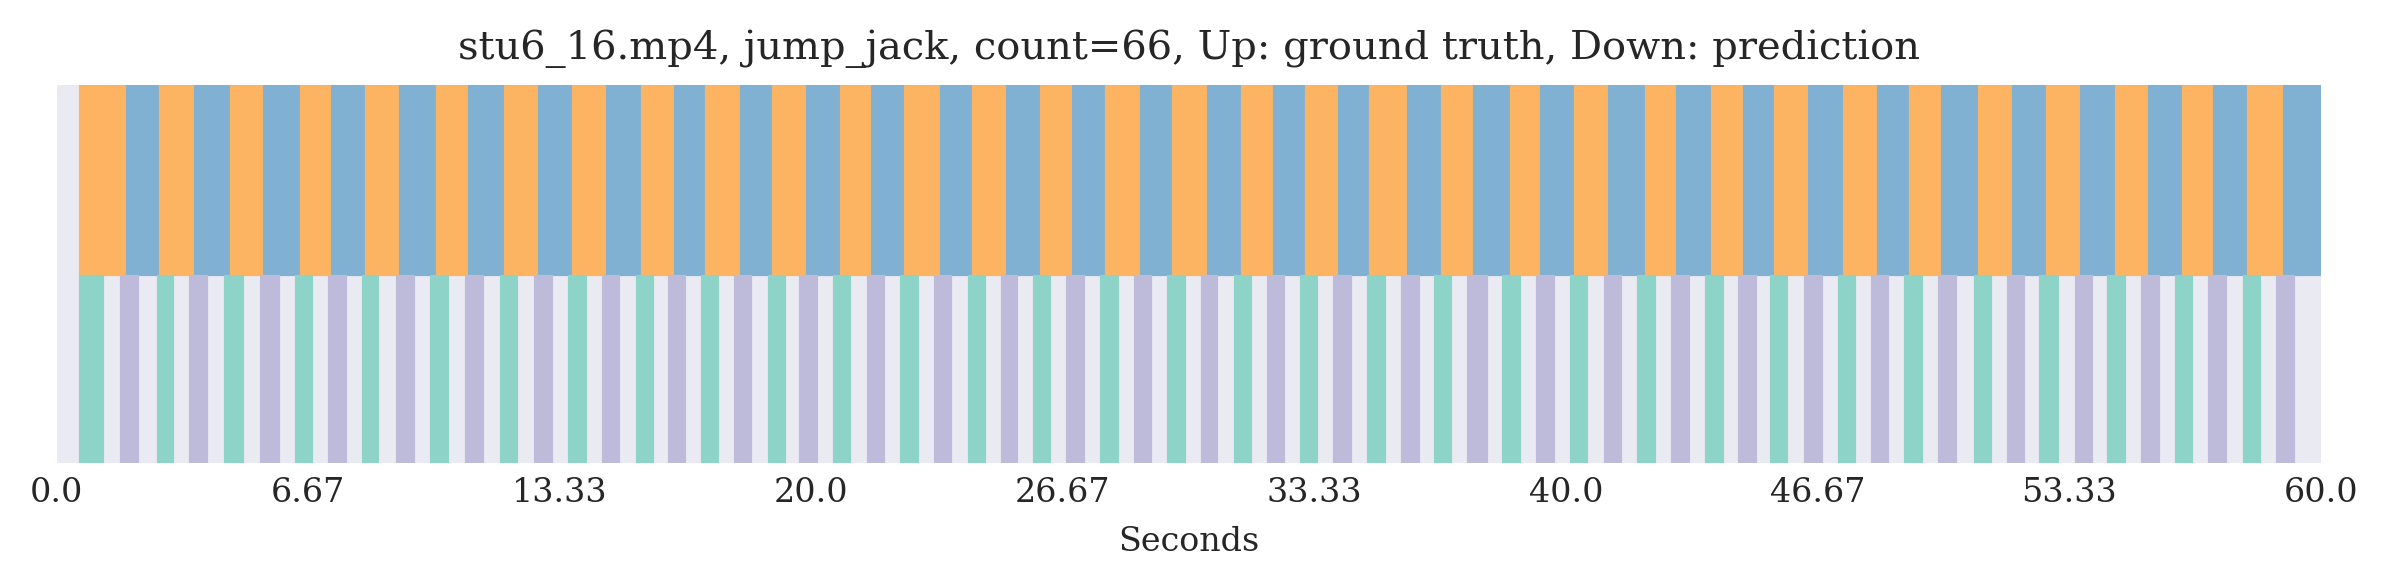

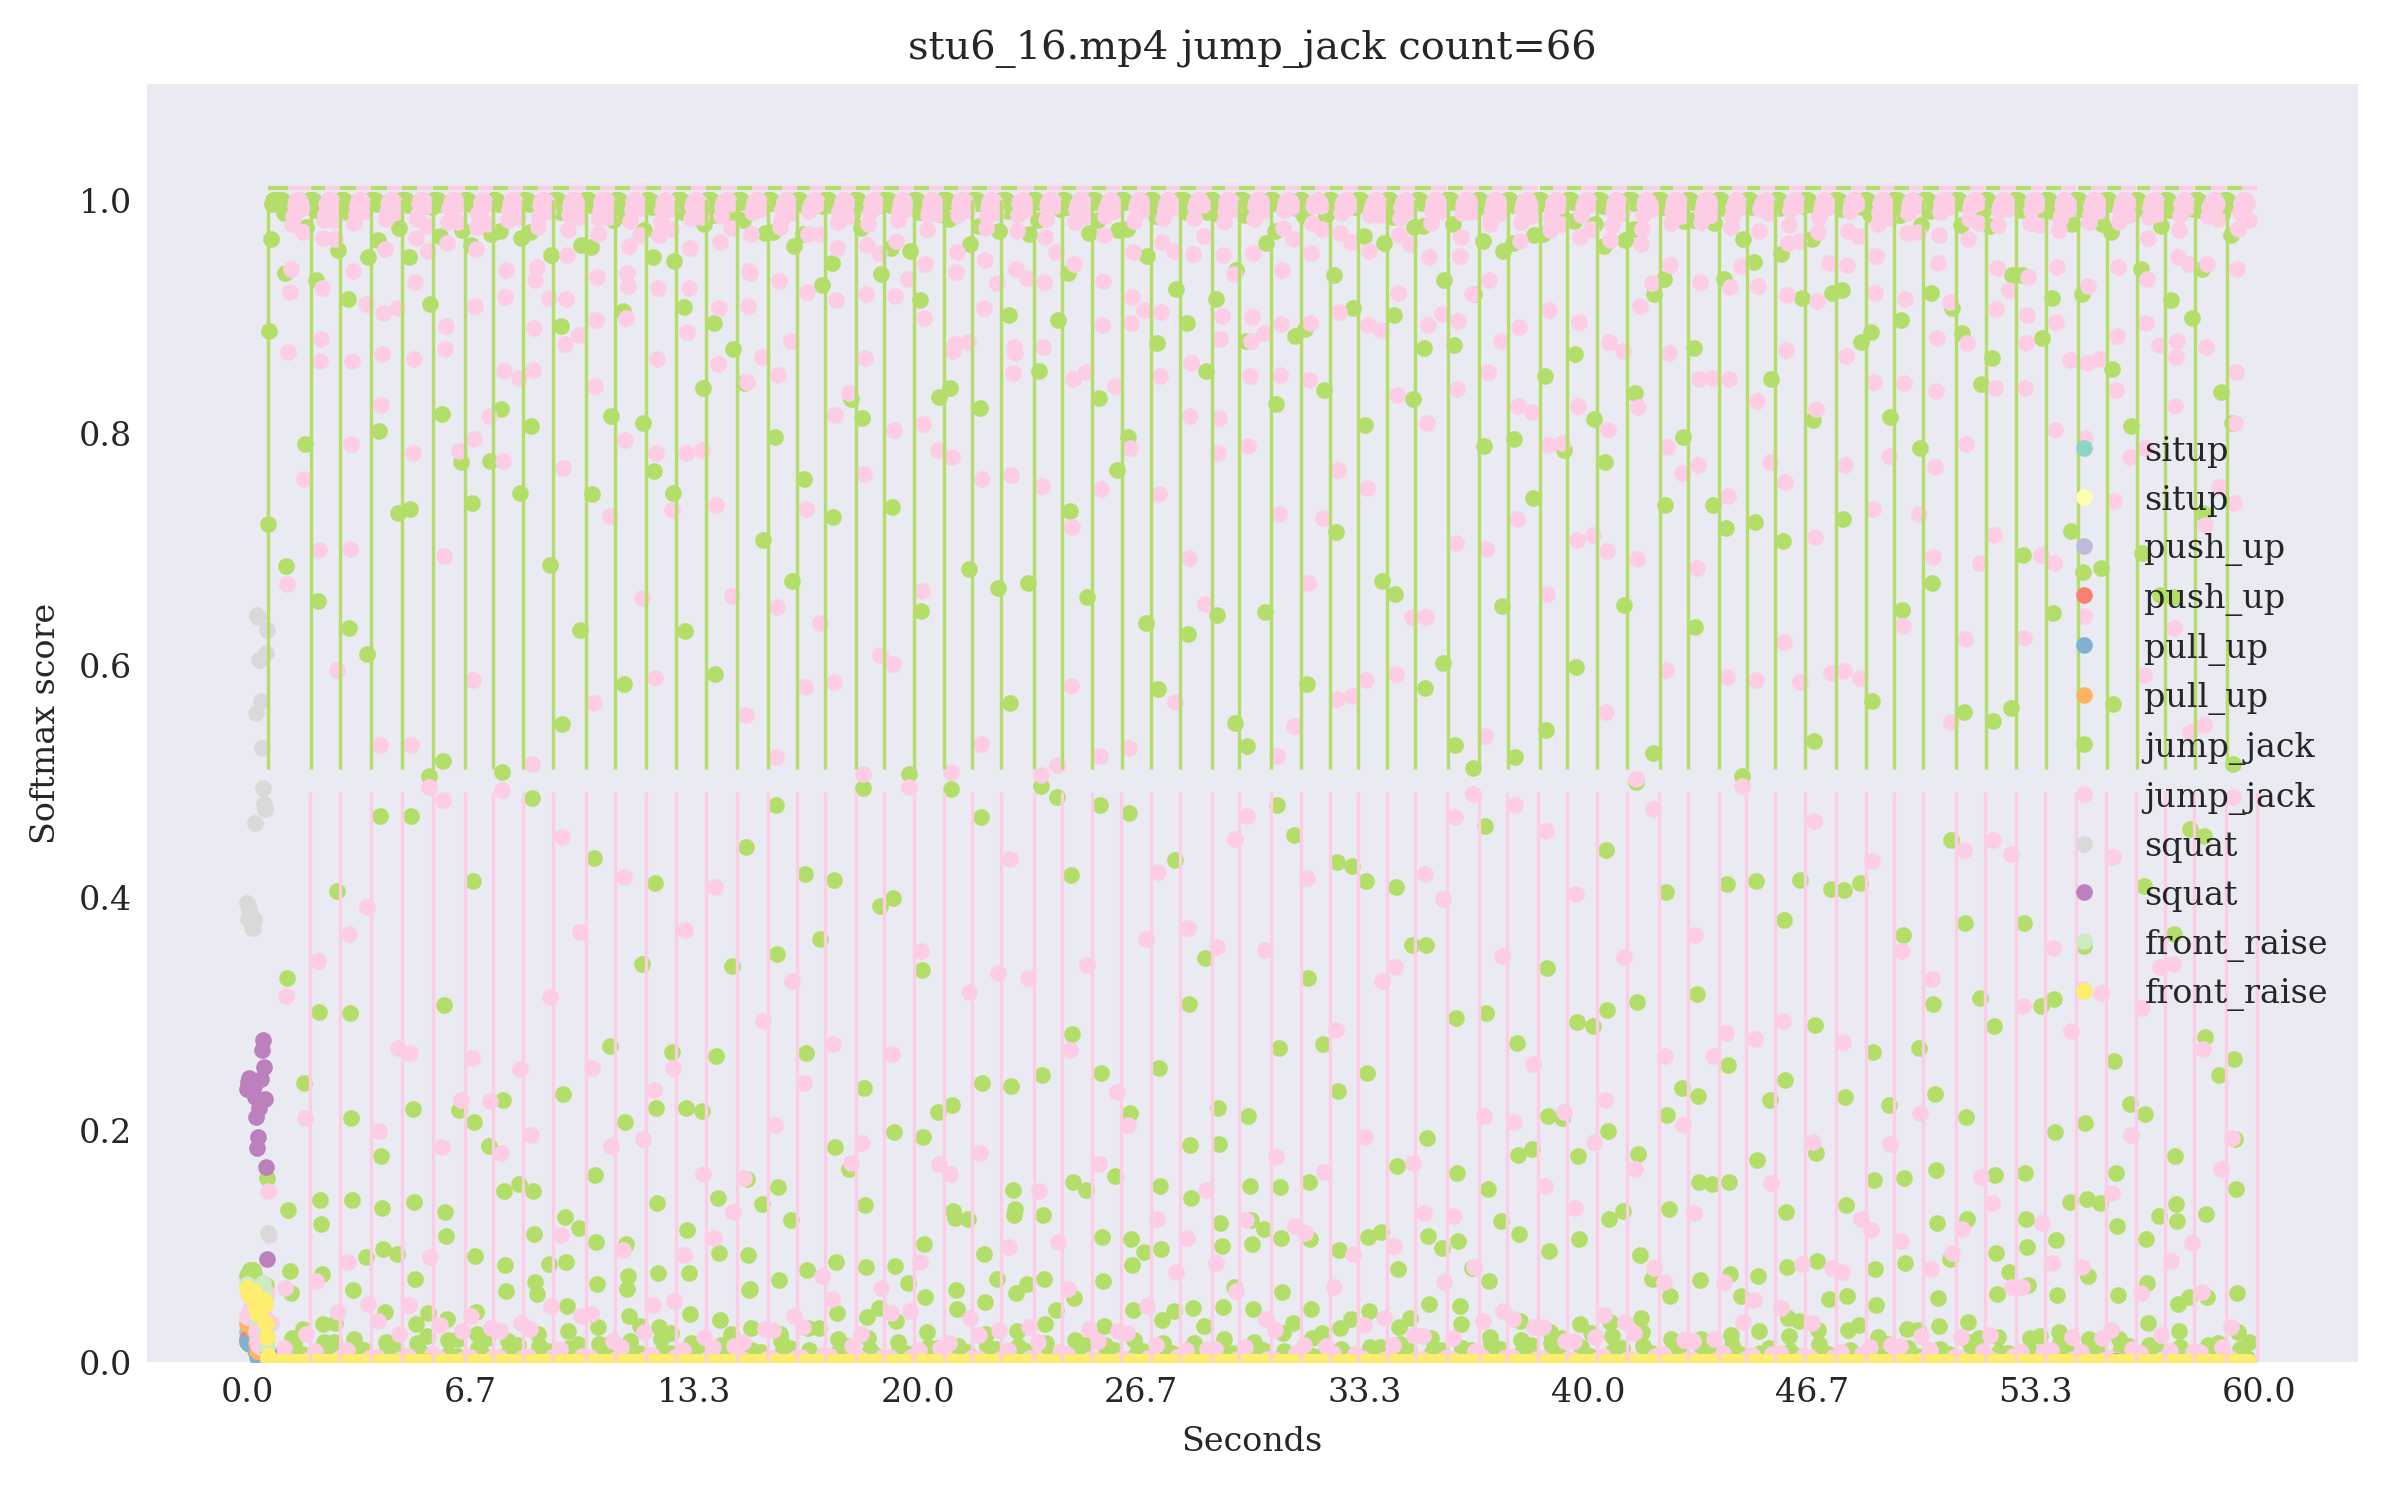

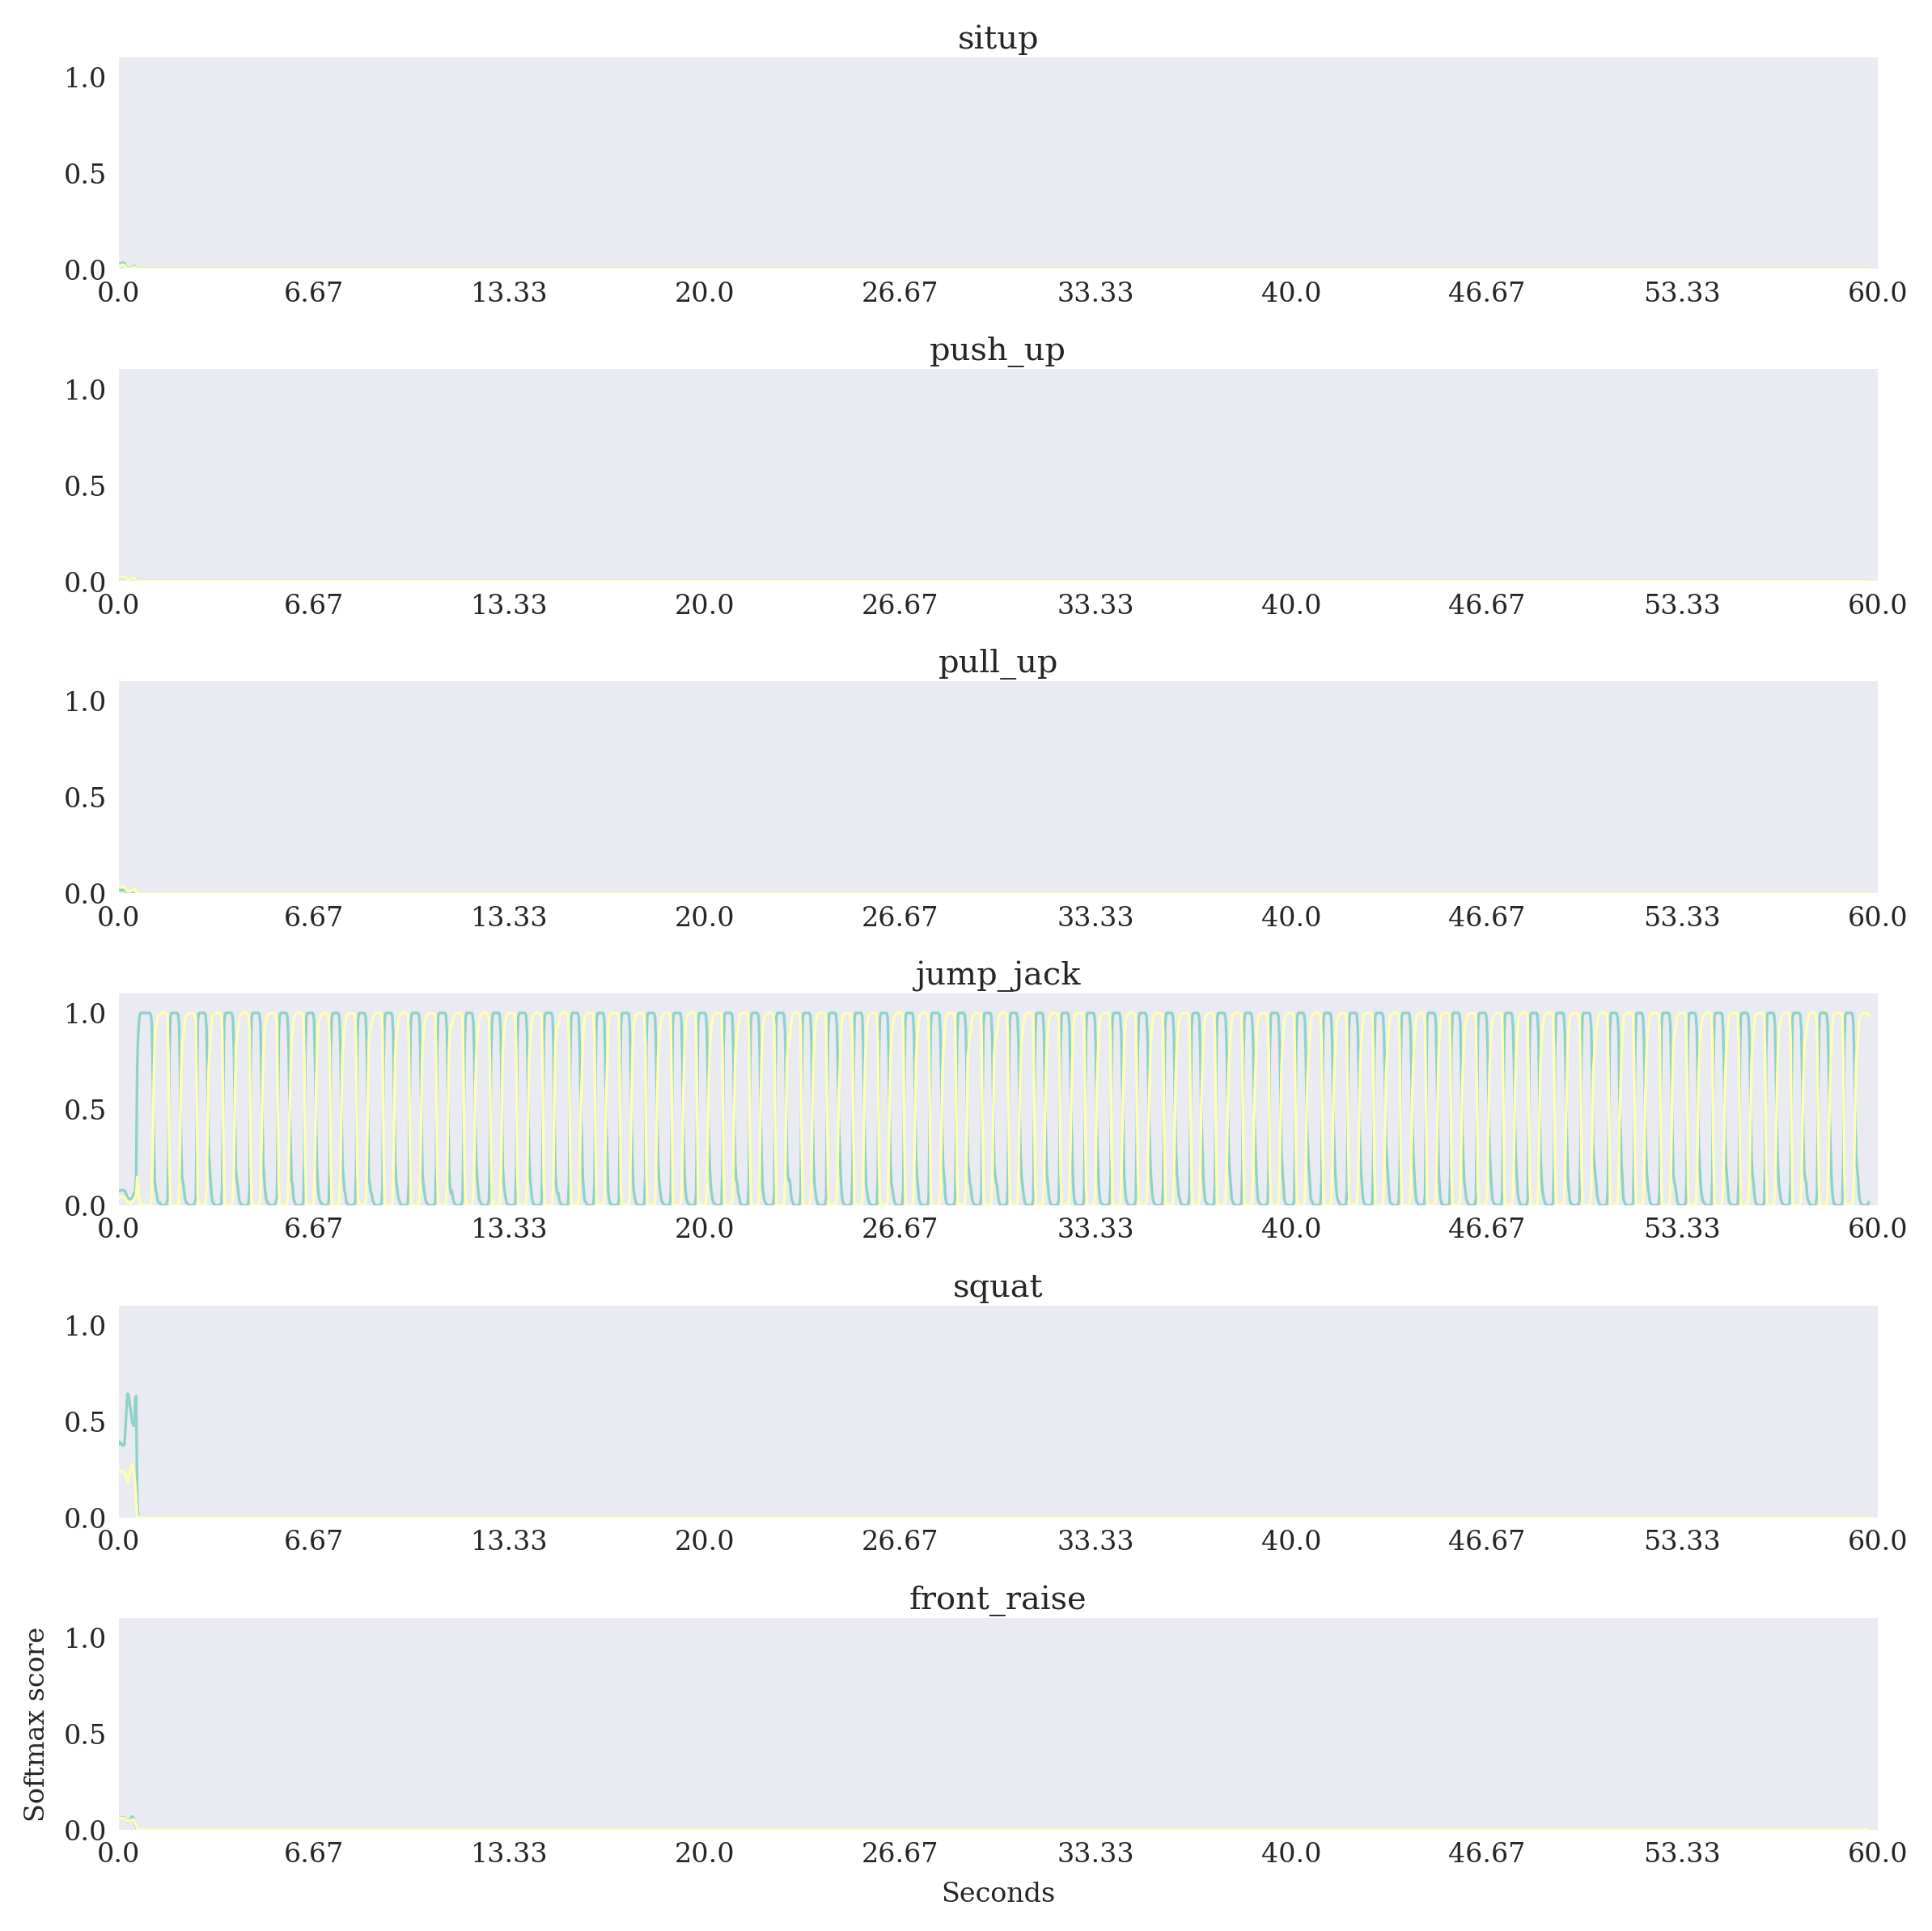

In [21]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
print(js['video_name'])
gt = np.array(js['ground_truth'])
score = js['scores']
threshold = 0.5
# print(score.values())
pred = []

for v in score.values():
    softmax_score = F.softmax(torch.Tensor(list(v.values())), dim=0)
    max_idx = torch.argmax(softmax_score)
    class_id, sc = max_idx.item(), softmax_score[max_idx].item()
    if sc >= threshold:
        pred.append(int(class_id))
    else:
        pred.append(-1)
# print(pred)
result = pred_to_count(pred, step=1)
print(result[1])
print(f'gt={len(gt)//2}, pred={result[0]}')
print('Absolute diff', abs(result[0] - len(gt) // 2))

plot_pred(result[1], gt, js['total_frames'], info=js, step=1)
plot_all(gt, info=js, softmax=True, stride=1)
plot_per_action(info=js, softmax=True)

# write_to_video(video_path=os.path.join('/home/user/data/RepCount/videos', x.split, x.video_name),
#                output_path=f'../out/{x.video_name}',
#                reps=result[1],
#                states=pred,
#                step=8)
